In [6]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import torch.utils.data as Data
plt.ion()

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(64),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/DATA/catdog/64'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

test_x,test_y = next(iter(dset_loaders['val']))
test_x = Variable(test_x)

use_gpu = torch.cuda.is_available()

In [13]:
print(len(dsets['train']))
print(len(dsets['val']))

20000
5000


In [14]:
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 60               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 4
LR = 0.001         

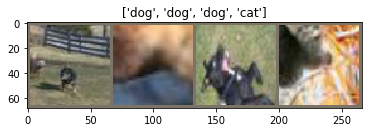

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=64,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=1,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            #nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 64, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 1),     
            nn.ReLU(),                      
            #nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(128, 128, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv5 = nn.Sequential(         
            nn.Conv2d(128, 256, 3, 1, 1),     
            nn.ReLU(),                      
            #nn.MaxPool2d(2),                
        )
        self.conv6 = nn.Sequential(         
            nn.Conv2d(256, 256, 3, 1, 1),    
            nn.ReLU(),                      
            #nn.MaxPool2d(2),                
        )
        self.conv7 = nn.Sequential(         
            nn.Conv2d(256, 256, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv8 = nn.Sequential(         
            nn.Conv2d(256, 512, 3, 1, 1),    
            nn.ReLU(),                      
            #nn.MaxPool2d(2),                
        )
        self.conv9 = nn.Sequential(        
            nn.Conv2d(512, 512, 3, 1, 1),    
            nn.ReLU(),                     
            #nn.MaxPool2d(2),                
        )
        self.conv10 = nn.Sequential(        
            nn.Conv2d(512, 512, 3, 1, 1),    
            nn.ReLU(),                      
            nn.MaxPool2d(2),             
        )
        self.conv11 = nn.Sequential(         
            nn.Conv2d(512, 512, 3, 1, 1),     
            nn.ReLU(),                     
            #nn.MaxPool2d(2),                
        )
        self.conv12 = nn.Sequential(         
            nn.Conv2d(512, 512, 3, 1, 1),     
            nn.ReLU(),                      
            #nn.MaxPool2d(2),                
        )
        self.conv13 = nn.Sequential(         
            nn.Conv2d(512, 512, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.fc1 = nn.Linear(512 * 2 * 2, 4096)   # fully connected layer, output n classes
        self.dp1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dp2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        output = self.fc3(x)
        return output, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

#plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(dset_loaders['train']):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)
#            if HAS_SK:
                
                # Visualization of trained flatten layer (T-SNE)
#                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#                plot_only = 500
#                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
#                labels = test_y.numpy()[:plot_only]
#                plot_with_labels(low_dim_embs, labels)
#plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

CNN (
  (conv1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
  )
  (conv2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv3): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
  )
  (conv4): Sequential (
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv5): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
  )
  (conv6): Sequential (
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
  )
  (conv7): Sequential (
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (

KeyboardInterrupt: 

In [ ]:
#save net and parms
torch.save(cnn, 'net.pkl')

In [ ]:
#load net and test
net2 = torch.load('net.pkl')
test_output, _ = net2(test_x[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:20].numpy(), 'real number')
